"""  
功能：不使用OpenCV时Canny边缘检测的Python实现

说明：


函数：

作者：tztang

参考资料：
[canny 算子python实现](https://www.cnblogs.com/king-lps/p/8007134.html)

日期：
        2019-04-16  
"""

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

求5*5大小的高斯核G，具体公式如下所示：    
$G(i,j)=\frac{1}{2\pi\sigma_{1}\sigma_{2}}exp\left( \frac{(i-(k+1))^{2}}{\sigma_{1}^{2}} + \frac{(j-(k+1))^2}{\sigma_{2}^{2}}\right);0 \leq i,j < (2k+1) $  

**说明** ：按照以上公式计算之后的高斯核需要归一化。

Src image size is
(400, 400, 3)


Text(0.5, 1.0, 'Src image')

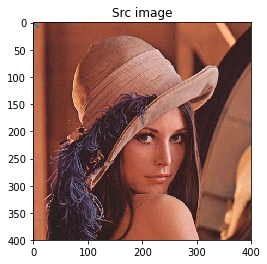

In [3]:
plt.plot(np.arange(10))
img = plt.imread('images/lena.jpg')
size = img.shape
print("Src image size is")
print(size)
plt.imshow(img)
plt.title('Src image')  # 图像题目

In [5]:
#生成二维高斯分布矩阵
# 说明：需要注意的是，以下代码中的注释部分，注释前后的计算结果一样，因而注释掉可以减少不必要的计算
sigma1 = sigma2 = 1
k = 1
sum = 0

gaussian = np.zeros([(2*k+1), (2*k+1)])
for i in range(2*k+1):
    for j in range(2*k+1):
        gaussian[i,j] = math.exp(-1/2 * (np.square(i-(k+1))/np.square(sigma1)  
                        + (np.square(j-(k+1))/np.square(sigma2)))) # / (2*math.pi*sigma1*sigma2)
        sum = sum + gaussian[i, j]
        
gaussian = gaussian/sum
print(gaussian)

[[0.0060366  0.02705418 0.0446048 ]
 [0.02705418 0.12124841 0.19990484]
 [0.0446048  0.19990484 0.32958736]]


Gray image size is 
(400, 400)


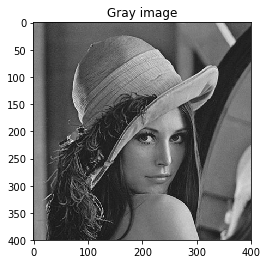

In [4]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

gray = rgb2gray(img)
size = gray.shape
print("Gray image size is ")
print(size)
plt.imshow(gray, cmap="gray")
plt.title('Gray image')  # 图像题目

After Gussian filter, image size is
(400, 400)


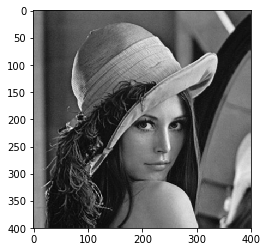

In [9]:
# step1.高斯滤波（Gaussian filtering）
# 说明：需要注意边缘处理
W, H = gray.shape
new_gray = np.zeros([W, H])
for i in range (W-3):
    for j in range (H-3):
        new_gray[i,j] = np.sum(gray[i:i+3,j:j+3]*gaussian)   # 与高斯矩阵卷积实现滤波 

for i in range(W-3,W):
    for j in range(H):
        new_gray[i,j] = new_gray[W-4,j]

for i in range(W):
    for j in range(H-3,W):
        new_gray[i,j] = new_gray[i,H-4]
print("After Gussian filter, image size is" )
print(new_gray.shape)
plt.imshow(new_gray, cmap="gray")

400 400


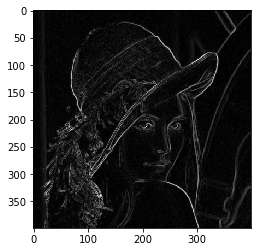

In [10]:
# step2.增强 通过求梯度幅值
W1, H1 = new_gray.shape
print(W1,H1)
dx = np.zeros([W1-1, H1-1])
dy = np.zeros([W1-1, H1-1])
d = np.zeros([W1-1, H1-1])
for i in range(W1-1):
    for j in range(H1-1):   
        dx[i,j] = new_gray[i, j+1] - new_gray[i, j]
        dy[i,j] = new_gray[i+1, j] - new_gray[i, j]        
        d[i, j] = np.sqrt(np.square(dx[i,j]) + np.square(dy[i,j]))   # 图像梯度幅值作为图像强度值
         
plt.imshow(d, cmap="gray")

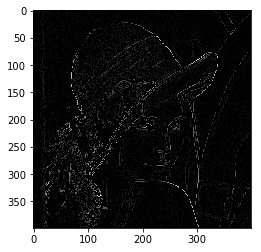

In [7]:
# setp3.非极大值抑制 NMS
W2, H2 = d.shape
NMS = np.copy(d)
NMS[0,:] = NMS[W2-1,:] = NMS[:,0] = NMS[:, H2-1] = 0
for i in range(1, W2-1):
    for j in range(1, H2-1):
        
        if d[i, j] == 0:
            NMS[i, j] = 0
        else:
            gradX = dx[i, j]
            gradY = dy[i, j]
            gradTemp = d[i, j]
            
            # 如果Y方向幅度值较大
            if np.abs(gradY) > np.abs(gradX):
                weight = np.abs(gradX) / np.abs(gradY)
                grad2 = d[i-1, j]
                grad4 = d[i+1, j]
                # 如果x,y方向梯度符号相同
                if gradX * gradY > 0:
                    grad1 = d[i-1, j-1]
                    grad3 = d[i+1, j+1]
                # 如果x,y方向梯度符号相反
                else:
                    grad1 = d[i-1, j+1]
                    grad3 = d[i+1, j-1]
                    
            # 如果X方向幅度值较大
            else:
                weight = np.abs(gradY) / np.abs(gradX)
                grad2 = d[i, j-1]
                grad4 = d[i, j+1]
                # 如果x,y方向梯度符号相同
                if gradX * gradY > 0:
                    grad1 = d[i+1, j-1]
                    grad3 = d[i-1, j+1]
                # 如果x,y方向梯度符号相反
                else:
                    grad1 = d[i-1, j-1]
                    grad3 = d[i+1, j+1]
        
            gradTemp1 = weight * grad1 + (1-weight) * grad2
            gradTemp2 = weight * grad3 + (1-weight) * grad4
            if gradTemp >= gradTemp1 and gradTemp >= gradTemp2:
                NMS[i, j] = gradTemp
            else:
                NMS[i, j] = 0
        
plt.imshow(NMS, cmap = "gray")

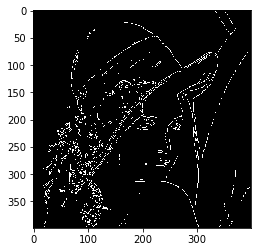

In [8]:
# step4. 双阈值算法检测、连接边缘
W3, H3 = NMS.shape
DT = np.zeros([W3, H3])               
# 定义高低阈值
TL = 0.2 * np.max(NMS)
TH = 0.3 * np.max(NMS)
for i in range(1, W3-1):
    for j in range(1, H3-1):
        if (NMS[i, j] < TL):
            DT[i, j] = 0
        elif (NMS[i, j] > TH):
            DT[i, j] = 1
        elif ((NMS[i-1, j-1:j+1] < TH).any() or (NMS[i+1, j-1:j+1]).any() 
              or (NMS[i, [j-1, j+1]] < TH).any()):
            DT[i, j] = 1
        
plt.imshow(DT, cmap = "gray")